<h1>Part I</h1>
<h5>Load in the data file and header file provided - The dataframe does not currently have a header, load in the header file and attach it to the dataframe<h5>
>To perform Data Enrichment

In [42]:
import numpy as np
import pandas as pd

In [43]:
with open("data/field_names.txt", "r") as file:
    attributes_names = file.read().split("\n")

In [44]:
print(attributes_names)

['ID', 'diagnosis', 'radius_mean', 'radius_sd_error', 'radius_worst', 'texture_mean', 'texture_sd_error', 'texture_worst', 'perimeter_mean', 'perimeter_sd_error', 'perimeter_worst', 'area_mean', 'area_sd_error', 'area_worst', 'smoothness_mean', 'smoothness_sd_error', 'smoothness_worst', 'compactness_mean', 'compactness_sd_error', 'compactness_worst', 'concavity_mean', 'concavity_sd_error', 'concavity_worst', 'concave_points_mean', 'concave_points_sd_error', 'concave_points_worst', 'symmetry_mean', 'symmetry_sd_error', 'symmetry_worst', 'fractal_dimension_mean', 'fractal_dimension_sd_error', 'fractal_dimension_worst']


In [45]:
df1 = pd.read_csv("data/breast-cancer.csv", names=attributes_names)

In [46]:
print(df1.head())

         ID diagnosis  radius_mean  radius_sd_error  radius_worst  \
0    842302         M        17.99            10.38        122.80   
1    842517         M        20.57            17.77        132.90   
2  84300903         M        19.69            21.25        130.00   
3  84348301         M        11.42            20.38         77.58   
4  84358402         M        20.29            14.34        135.10   

   texture_mean  texture_sd_error  texture_worst  perimeter_mean  \
0        1001.0           0.11840        0.27760          0.3001   
1        1326.0           0.08474        0.07864          0.0869   
2        1203.0           0.10960        0.15990          0.1974   
3         386.1           0.14250        0.28390          0.2414   
4        1297.0           0.10030        0.13280          0.1980   

   perimeter_sd_error  ...  concavity_worst  concave_points_mean  \
0             0.14710  ...            25.38                17.33   
1             0.07017  ...            24

#Comment on any steps you might take to evaluate or transform the dataset.
>When we perform the computation for statistical test to validate if smoothness mean for malignant and benign is indeed different, we would be required to satisfy the parametric criteria of normality. This applies the same to compactness mean for malignant and benign

<h3>Compute the mean and median smoothness and compactness for benign and malignant tumors - do they differ? </h3>
>To perform statistical validation

In [47]:
df1.groupby('diagnosis').agg([np.mean, np.median])[['smoothness_mean','compactness_mean']]


smoothness_mean         compactness_mean         
                     mean  median             mean   median
diagnosis                                                  
B                2.000321  1.8510         0.021438  0.01631
M                4.323929  3.6795         0.032281  0.02859

<h3>Explain how you would identify this.</h3>
>Conduct a visual dist check with its KDE, if failed proceed to normality test <br>
>Use Non-parametric test for both median and mean to evaluate if they differ

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

<Figure size 1440x1080 with 0 Axes>

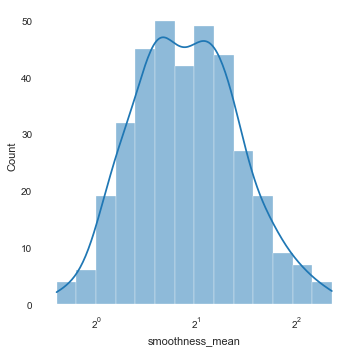

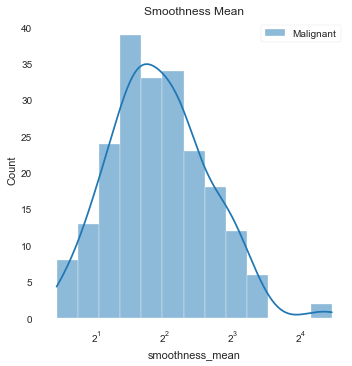

In [49]:
plt.figure(figsize=(20,15))

sns.displot(df1[df1["diagnosis"]=="B"]["smoothness_mean"], label = "Benign",log_scale=2,kde=True)
sns.displot(df1[df1["diagnosis"]=="M"]["smoothness_mean"], label = "Malignant",log_scale=2,kde=True)
plt.title("Smoothness Mean")
plt.legend()
plt.show()
#no extreme outliers

In [50]:
from scipy.stats import normaltest 

stat, p = normaltest(np.log2(df1[df1["diagnosis"]=="M"]["smoothness_mean"])) 

#We test for both Malignant and Benign situtation i.e. change "M" to "B" and "smoothness_mean" to compactness_mean"

#since p value is < 0.05, they are approximately normally distributed

In [51]:
(test_statistic, p_value) = stats.levene(np.log2(df1[df1["diagnosis"]=="M"]["smoothness_mean"]),np.log2(df1[df1["diagnosis"]=="B"]["smoothness_mean"]),center='mean')
print("The test statistic is: ", round(test_statistic,5))
print("The p-value is: ", round(p_value,5))
#they are unequal in variance

The test statistic is:  21.50128
The p-value is:  0.0


In [52]:
(test_statistic, p_value) = stats.ttest_ind(np.log2(df1[df1["diagnosis"]=="M"]["smoothness_mean"]),np.log2(df1[df1["diagnosis"]=="B"]["smoothness_mean"]), equal_var =False, nan_policy='omit')
#we test for both smoothness and compactness i.e. changed smoothness to compactness
#Parametric T test validates if the mean differs for both benign and malignant tumors

print("The p-value is: ", round(p_value,5))
#t converge to z based on CLT and n>60.
#they are unequal. Testing on mannwhitney u is the same result

The p-value is:  0.0


In [53]:
(test_statistic, p_value) = stats.mannwhitneyu(df1[df1["diagnosis"]=="M"]["smoothness_mean"],df1[df1["diagnosis"]=="B"]["smoothness_mean"])
#we test for both smoothness and compactness i.e. changed smoothness to compactness
#Non-parametric T test validates if the median differs for both benign and malignant tumors

print("The p-value is: ", round(p_value,5))
#Testing on mannwhitney yields the same result

The p-value is:  0.0


>At significance level of 5%, we reject the null hypothesis for either Compactness/Smoothness: No Difference and <br>
>conclude that the Diagnosis mean of first group(t1: Malignant Compactness/Smoothness Mean) is different to that of the Diagnosis mean of the second group(t2: Benign Compactness/Smoothness Mean) <br>
>Repeating the test we find that it is the same conclusion

<h3>Write a function to generate bootstrap samples of the data.</h3>


In [54]:
def generate_bootstrap(sample_data, no_of_bsample, bsample_size):
    bsamples = []
    for i in range(no_of_bsample):
        bsample = sample_data.sample(n = bsample_size, replace=True)
        bsamples.append(bsample)
    return bsamples

In [55]:
bootstrap_resampled = generate_bootstrap(df1, 3, 10)


<h2>Exploratory Data Analysis</h2>

In [56]:
from pandas_profiling import ProfileReport

EDA = ProfileReport(df1)
EDA.to_file(output_file='output1.html')

#Check for nulls, distribution, outliers, etc...

C:\Users\johns\AppData\Roaming\Python\Python37\site-packages\pandas_profiling\visualisation\plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


####
Exploratory Analysis
Identify 2-3 variables that are predictive of a malignant tumor.
Display the relationship visually and write 1-2 sentences explaining the relationship.
Modeling
Build a model to predict the malignant tumors.
Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.
Identify how you would control for overfitting in each classification technique.
Evaluate the performance of each model.
In each model, identify the most important predictive variables and explain how you identified them.
Explanation
To Technical Audiences
Explain the limitations of your analysis and identify possible further steps you could take.
To Non-Technical Audiences
Write a short summary of your analysis, explaining how your model works and how it performs.
Briefly explain the factors that contributed to malignant vs benign tumor identification.

<h3>Identify 2-3 variables that are predictive of a malignant tumor.</h3>


<h3>Display the relationship visually and write 1-2 sentences explaining the relationship.</h3>
>Step1: Perform overall the non-parametric Correlation checks (because raw data follows a non-parametric requirement)
>Step2: Filter for highly correlated variable (>70%)
>Step3: Take a bivariate comparison on those highly correlated variable to see if there is a plausible multi-collinearity (>90%) issues between IVs
>Step4: Perform a Feature selection and pick the first three that are not multi-collinear IVs as it would affect the model

In [57]:
#recoding to numeric before performing correlation
df2 = df1.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)


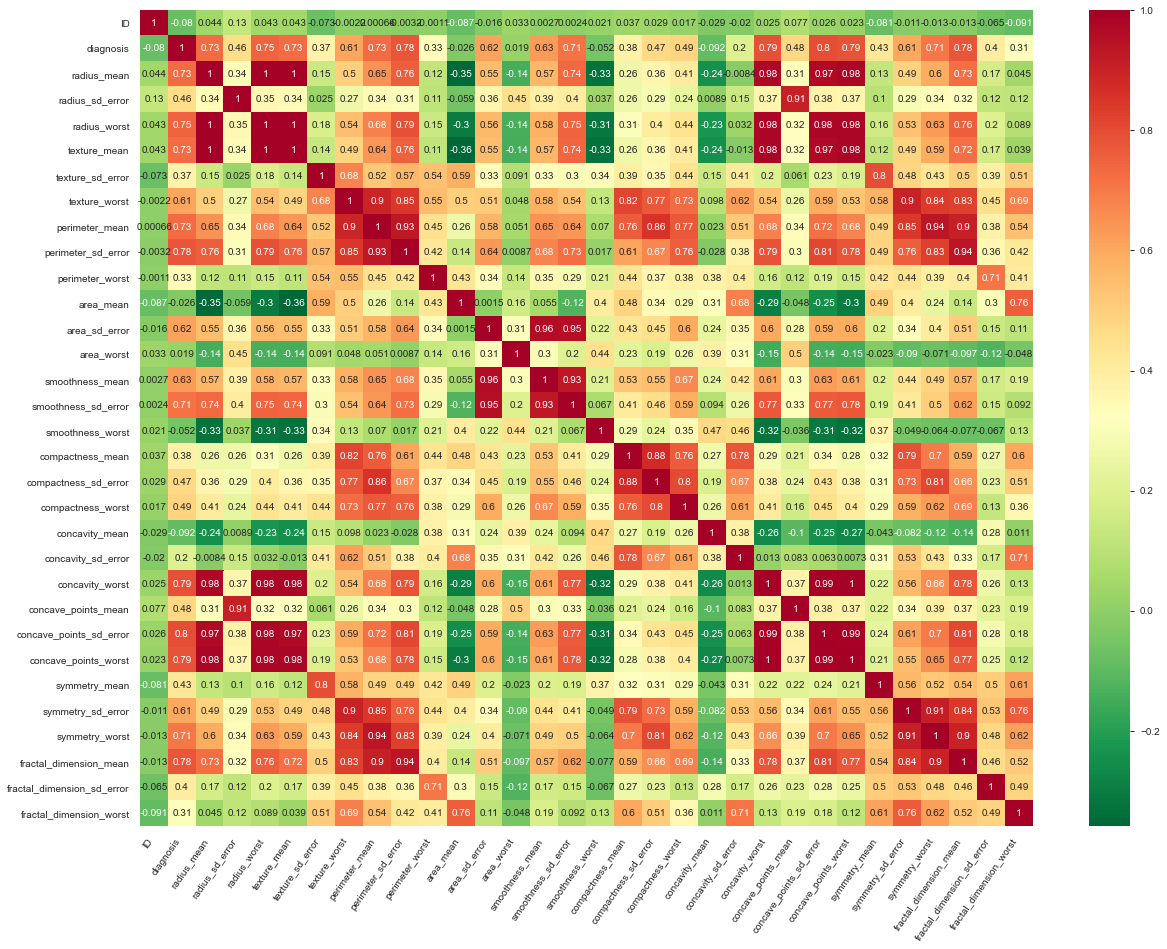

In [58]:
#Using Spearman since the original dataset is non-parametric
correl_df1=df1.corr(method="spearman")
plt.figure(figsize=(20,15))

ax = sns.heatmap(correl_df1, annot=True, cmap='RdYlGn_r')

ax.set_xticklabels(correl_df1, rotation=55, ha='right')

plt.show()

In [59]:
#Compute features correlation with diagnosis variable
#Correlation with output variable
correl = df1.corr(method="spearman")
correl_abs = abs(correl["diagnosis"])
#Filtering for the highly correlated features (those with correlation score >0.7)
filtered_IVs = correl_abs[correl_abs>0.7]
filtered_IVs = filtered_IVs.sort_values(ascending=False)[1:]

print("Features and Correlation Score \n", filtered_IVs)



Features and Correlation Score 
 concave_points_sd_error    0.796319
concavity_worst            0.787933
concave_points_worst       0.786902
fractal_dimension_mean     0.781674
perimeter_sd_error         0.777877
radius_worst               0.748496
texture_mean               0.734122
perimeter_mean             0.733308
radius_mean                0.732785
smoothness_sd_error        0.714184
symmetry_worst             0.705734
Name: diagnosis, dtype: float64


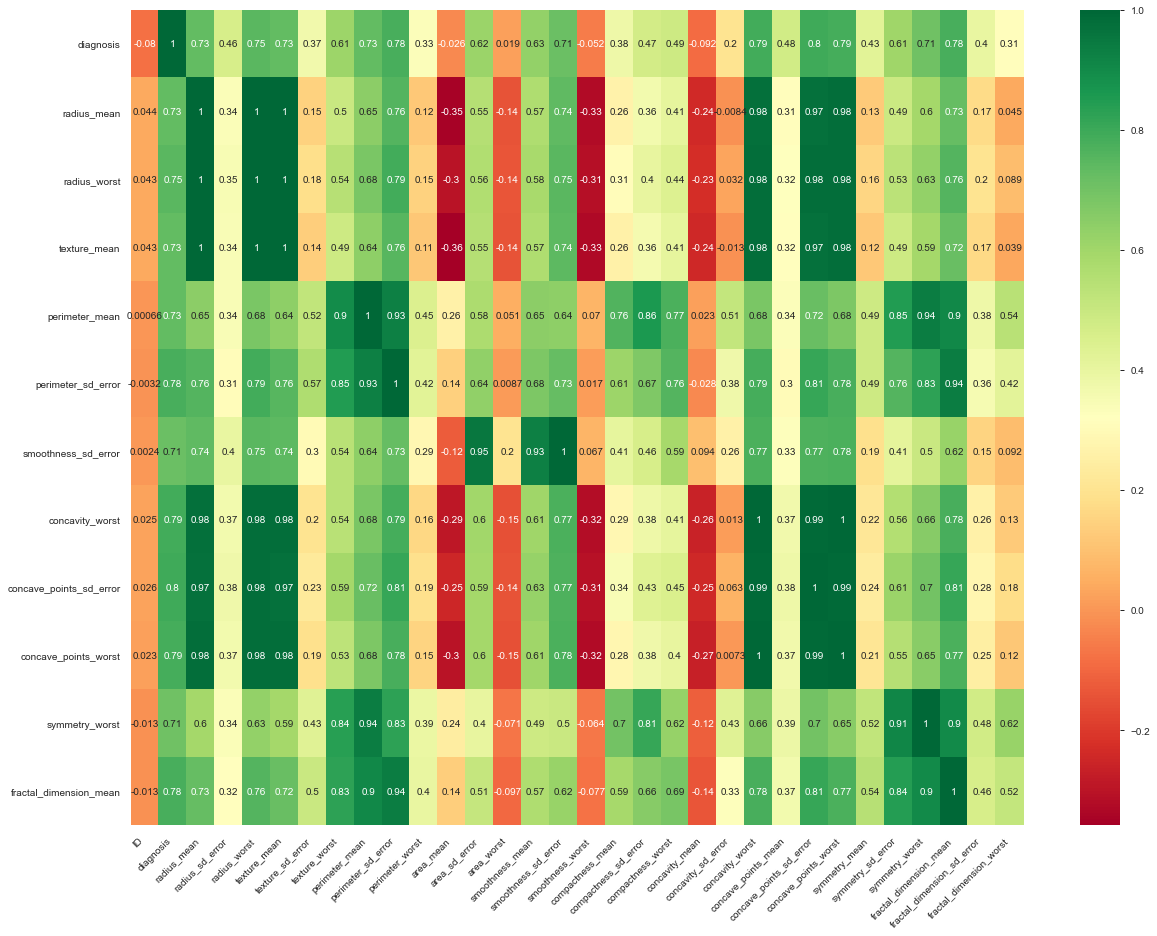

In [60]:
correl_df1=df1.corr(method="spearman")
# cor_target = abs(correl_df1["diagnosis"])
cor_target = abs(correl_df1['diagnosis']) 



relevant_features = correl_df1[cor_target>0.7]



plt.figure(figsize=(20,15))

ax = sns.heatmap(relevant_features, annot=True, cmap="RdYlGn")

ax.set_xticklabels(relevant_features, rotation=45, ha='right')

plt.show()

In [61]:
filtered_IVs = filtered_IVs.keys().tolist()
filtered_IV2 = correl_df1.loc[filtered_IVs,filtered_IVs]
print("Variables that are predictive of a malignant tumor")
display(filtered_IV2)

Variables that are predictive of a malignant tumor


,concave_points_sd_error,concavity_worst,concave_points_worst,fractal_dimension_mean,perimeter_sd_error,radius_worst,texture_mean,perimeter_mean,radius_mean,smoothness_sd_error,symmetry_worst
concave_points_sd_error,1.000000,0.993548,0.992433,0.812983,0.813960,0.978980,0.971822,0.722424,0.971555,0.768336,0.700572
concavity_worst,0.993548,1.000000,0.998891,0.780632,0.787411,0.981244,0.979258,0.682316,0.978604,0.774244,0.655942
concave_points_worst,0.992433,0.998891,1.000000,0.773945,0.780395,0.980864,0.980264,0.676628,0.978863,0.775662,0.651120
fractal_dimension_mean,0.812983,0.780632,0.773945,1.000000,0.937075,0.757526,0.723390,0.904938,0.727265,0.619539,0.902301
perimeter_sd_error,0.813960,0.787411,0.780395,0.937075,1.000000,0.788629,0.755165,0.927352,0.759702,0.726982,0.827281
radius_worst,0.978980,0.981244,0.980864,0.757526,0.788629,1.000000,0.997068,0.681958,0.997802,0.745824,0.632106
texture_mean,0.971822,0.979258,0.980264,0.723390,0.755165,0.997068,1.000000,0.642557,0.999602,0.741518,0.593736
perimeter_mean,0.722424,0.682316,0.676628,0.904938,0.927352,0.681958,0.642557,1.000000,0.645728,0.644344,0.938543
radius_mean,0.971555,0.978604,0.978863,0.727265,0.759702,0.997802,0.999602,0.645728,1.000000,0.738077,0.596043
smoothness_sd_error,0.768336,0.774244,0.775662,0.619539,0.726982,0.745824,0.741518,0.644344,0.738077,1.000000,0.500307


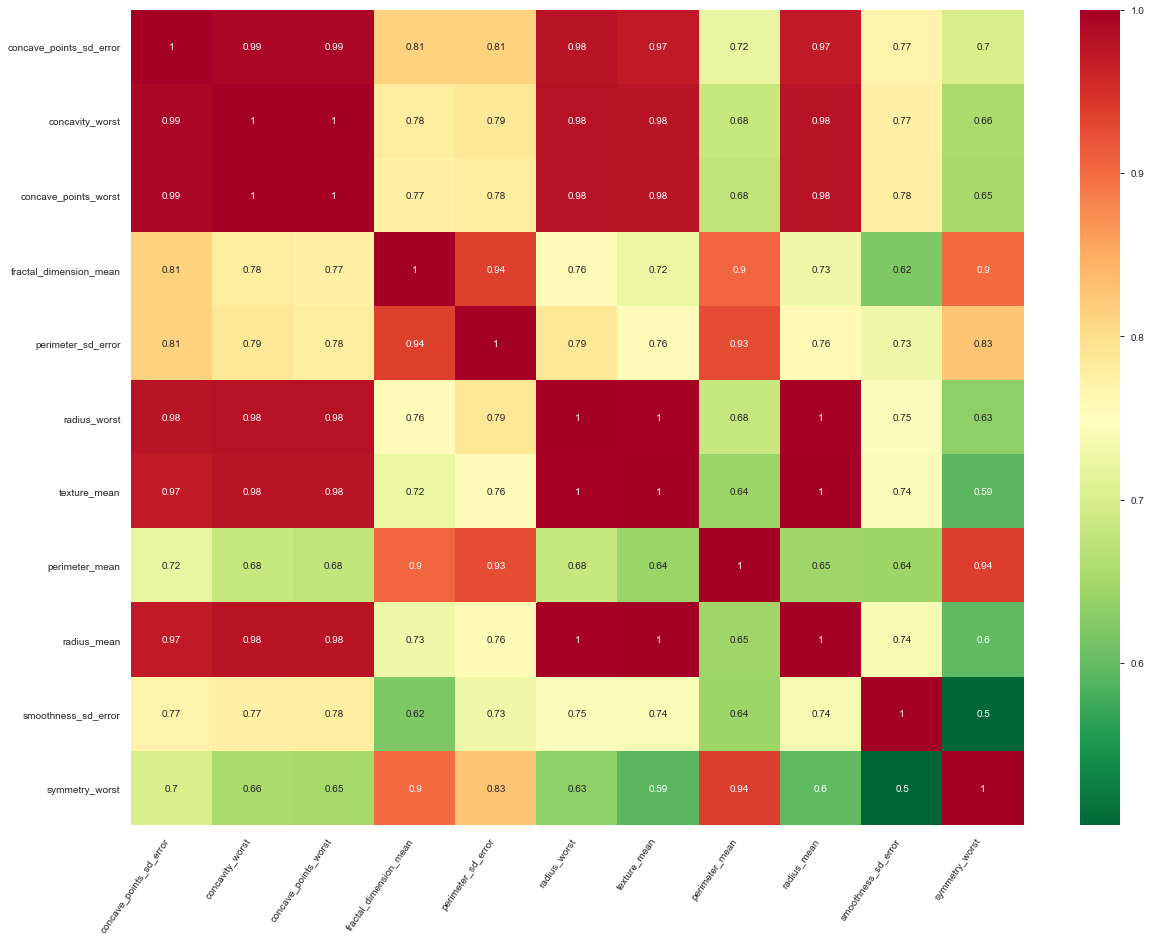

In [62]:
plt.figure(figsize=(20,15))

ax = sns.heatmap(filtered_IV2, annot=True, cmap="RdYlGn_r")

ax.set_xticklabels(filtered_IV2, rotation=55, ha='right')

plt.show()

[0.05013764 0.02273843 0.07363672 0.05005828 0.01042201 0.02127215
 0.06993839 0.08062591 0.00724025 0.00530657 0.01534485 0.00571393
 0.02083556 0.03308596 0.00734576 0.00690063 0.01260717 0.01269852
 0.00643848 0.00622684 0.10052303 0.02991561 0.0662896  0.07333683
 0.01700777 0.02216846 0.05459677 0.09428841 0.01379405 0.00950545]


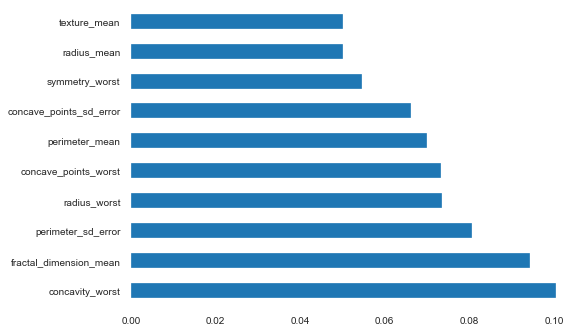

In [63]:
#perform a feature selection
X = df1.iloc[:,2:]  #IVs
y = df1.iloc[:,1]   #target column i.e diagnosis
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class

#feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()



In [64]:
#tabular comparison
filtered_IV2[filtered_IV2[filtered_IV2<0.9].notna()]

,concave_points_sd_error,concavity_worst,concave_points_worst,fractal_dimension_mean,perimeter_sd_error,radius_worst,texture_mean,perimeter_mean,radius_mean,smoothness_sd_error,symmetry_worst
concave_points_sd_error,NaN,NaN,NaN,0.812983,0.813960,NaN,NaN,0.722424,NaN,0.768336,0.700572
concavity_worst,NaN,NaN,NaN,0.780632,0.787411,NaN,NaN,0.682316,NaN,0.774244,0.655942
concave_points_worst,NaN,NaN,NaN,0.773945,0.780395,NaN,NaN,0.676628,NaN,0.775662,0.651120
fractal_dimension_mean,0.812983,0.780632,0.773945,NaN,NaN,0.757526,0.723390,NaN,0.727265,0.619539,NaN
perimeter_sd_error,0.813960,0.787411,0.780395,NaN,NaN,0.788629,0.755165,NaN,0.759702,0.726982,0.827281
radius_worst,NaN,NaN,NaN,0.757526,0.788629,NaN,NaN,0.681958,NaN,0.745824,0.632106
texture_mean,NaN,NaN,NaN,0.723390,0.755165,NaN,NaN,0.642557,NaN,0.741518,0.593736
perimeter_mean,0.722424,0.682316,0.676628,NaN,NaN,0.681958,0.642557,NaN,0.645728,0.644344,NaN
radius_mean,NaN,NaN,NaN,0.727265,0.759702,NaN,NaN,0.645728,NaN,0.738077,0.596043
smoothness_sd_error,0.768336,0.774244,0.775662,0.619539,0.726982,0.745824,0.741518,0.644344,0.738077,NaN,0.500307


In [65]:
#extract 2 most relevant features that are not correlated IVs
non_MultiCollinear_IVs = ['fractal_dimension_mean', 'concave_points_sd_error']

#with the greatest information also


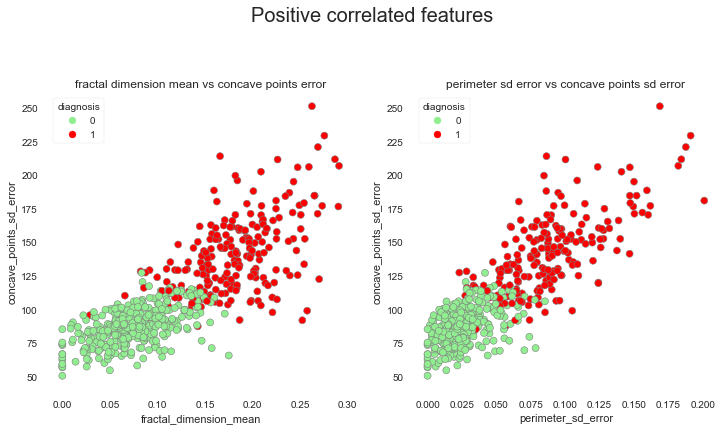

In [66]:
#Displaying their relationship
palette ={1 : 'red', 0 : 'lightgreen'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = df1['fractal_dimension_mean'], y = df1['concave_points_sd_error'], hue = "diagnosis",
                      data = df1, palette = palette, edgecolor=edgecolor)
plt.title('fractal dimension mean vs concave points error')

plt.subplot(222)
ax3 = sns.scatterplot(x = df1['perimeter_sd_error'], y = df1['concave_points_sd_error'], hue = "diagnosis",
                    data = df1, palette =palette, edgecolor=edgecolor)
plt.title('perimeter sd error vs concave points sd error')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.show()

In [67]:
df1[df1["diagnosis"]=="M"]["fractal_dimension_mean"]

C:\Users\johns\AppData\Roaming\Python\Python37\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


Series([], Name: fractal_dimension_mean, dtype: float64)

C:\Users\johns\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


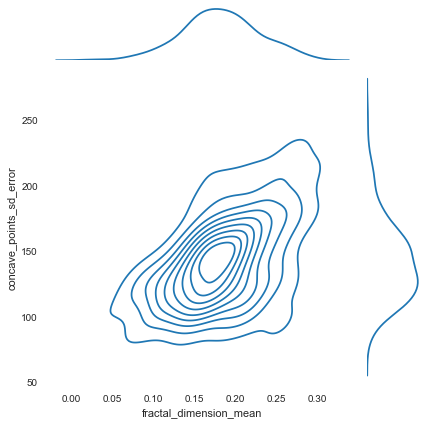

In [68]:
#For Malignant - they are concentrated within the highest core of the KDE density

sns.jointplot(df1[df1["diagnosis"]==1]["fractal_dimension_mean"],df1[df1["diagnosis"]==1]["concave_points_sd_error"], kind='kde')

C:\Users\johns\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


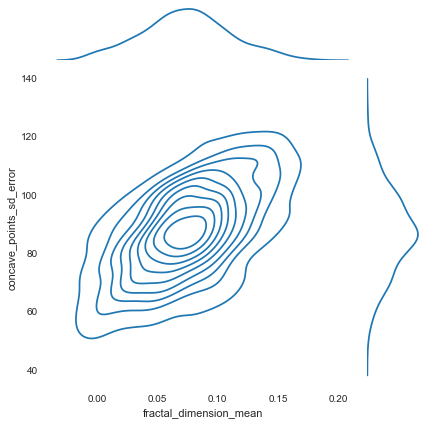

In [69]:
#For Benign - they are concentrated within the highest core of the KDE density
sns.jointplot(df1[df1["diagnosis"]==0]["fractal_dimension_mean"],df1[df1["diagnosis"]==0]["concave_points_sd_error"], kind='kde')

<h1>Modelling</h1>
<h2>Build a model to predict malignant tumors</h2>
>Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.

### Key highlights of the Advantages and Disadvantages of Logistic Regression (LR) vs Support Vector Classifier (SVC)
>Logistic Regression (LR) 
> - is a probabilistic classification model using the sigmoid function, whereas 
> - is a very fast and easiest to interpret mathematically on this classification model when compared to SVC and many other classifier. Since we related to Ln(Y) = mx + C
> - It focus on addressing the points together and find it hard to especially to classifying the hard to figured out data points, one example is the False negative you observed later i.e. 18 compared to SVC of 15. If those were the non-contextual extreme outliers, it should be treated first prior to running
> - For non-linear problems it is not as straight forth to use Logit link function because there may be encoding treatment and it may not work since LR works better in linear context
> - On Python: Can adopt various type of link function i.e. logit, probit but is not available in sklearn
> - On Python: Can use optimization such as liblinear, stochastic average gradient descent, etc... within LR function, does not require to rewrite the code to use the various types of gradient descent library


> Support Vector Classifier (SVC)
> - Takes a geometric approach that maximise the margins/boundaries to each class.
> - is very fast when dataset when the hyperplane is not too complex and challenging to mathematically interpret this classification model when compared to LR
> - It focus on subtle differences especially in classifying the hard to figured out data points, one example is the False negative you observed later i.e. 15 compared to Logistic regression of 18. However those may be non-contextual extreme outliers.
> - Can be extended to non-linear problem easily with adjustment of the configurations i.e. kernel, etc..
> - On Python: Can adopt various types of kernel such as linear to tackle linear problems or dataset with continous independent variable
> - On Python: Can also use various optimization but may need to rewrite the code to use the various types of the gradient descent library



In [70]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create training and test sets with randomized blocks

X_train, X_test, y_train, y_test = train_test_split(df1[non_MultiCollinear_IVs], df1['diagnosis'], test_size=0.3, random_state=12, shuffle=True)

In [71]:
#To control overfitting and imbalanced issues in each classification technique, perform Stratified K Fold cross validation
#StratifiedKFold shuffles the data, then splits it into n number of folds then the folds are each used as a testing set. Stratification keeps the balance between targets of the dataset (each stratified fold keeps the same ratio of the target classes). This strategy is best in cases of imbalanced data.


In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
from sklearn.model_selection import cross_val_score

# Conducting with the minimal runs and maximum effect(min sd vis-a-viz max auc score) i.e. 2 trials of 3 fold Cross Validation

def get_score(clf, X_train, y_train, X_test, y_test,SKF_n_split, train=True):
    if train:
        y_pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))    #report format
        cv = StratifiedKFold(n_splits=SKF_n_split, shuffle=True, random_state=12)   #evaluate the model
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)      
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, y_pred) * 100:.2f}%")
        print("_______________________________________________")
        print("Whilst the average AUC over {} fold Stratified Cross Validation is: {:.2f}%  \nwith a std deviation of {:.3f}".format(SKF_n_split,np.mean(scores)*100, np.std(scores)))
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, y_pred)}\n")
        
    elif train==False:
        y_pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
        cv = StratifiedKFold(n_splits=SKF_n_split, shuffle=True, random_state=12)
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
        print("_______________________________________________")
        print("Whilst the average AUC over {} fold Stratified Cross Validation is: {:.2f}%  \nwith a std deviation of {:.3f}".format(SKF_n_split, np.mean(scores)*100, np.std(scores)))
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")


In [73]:
# train the model and predict
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
get_score(svc, X_train, y_train, X_test, y_test, SKF_n_split=3,  train=False)

Test Result:
Accuracy Score: 85.96%
_______________________________________________
Whilst the average AUC over 3 fold Stratified Cross Validation is: 98.63%  
with a std deviation of 0.007
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.867257   0.844828  0.859649    0.856042      0.858862
recall       0.915888   0.765625  0.859649    0.840756      0.859649
f1-score     0.890909   0.803279  0.859649    0.847094      0.858112
support    107.000000  64.000000  0.859649  171.000000    171.000000
_______________________________________________
Confusion Matrix: 
 [[98  9]
 [15 49]]



In [74]:
from sklearn.linear_model import LogisticRegression

LogisticReg_clf = LogisticRegression(solver='liblinear')
LogisticReg_clf.fit(X_train, y_train)
get_score(LogisticReg_clf, X_train, y_train, X_test, y_test, SKF_n_split=3,   train=False)

Test Result:
Accuracy Score: 87.13%
_______________________________________________
Whilst the average AUC over 3 fold Stratified Cross Validation is: 98.46%  
with a std deviation of 0.005
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.851240   0.920000  0.871345    0.885620      0.876975
recall       0.962617   0.718750  0.871345    0.840683      0.871345
f1-score     0.903509   0.807018  0.871345    0.855263      0.867395
support    107.000000  64.000000  0.871345  171.000000    171.000000
_______________________________________________
Confusion Matrix: 
 [[103   4]
 [ 18  46]]



In [75]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend(loc="upper left")


Text(0, 0.5, 'Recall')

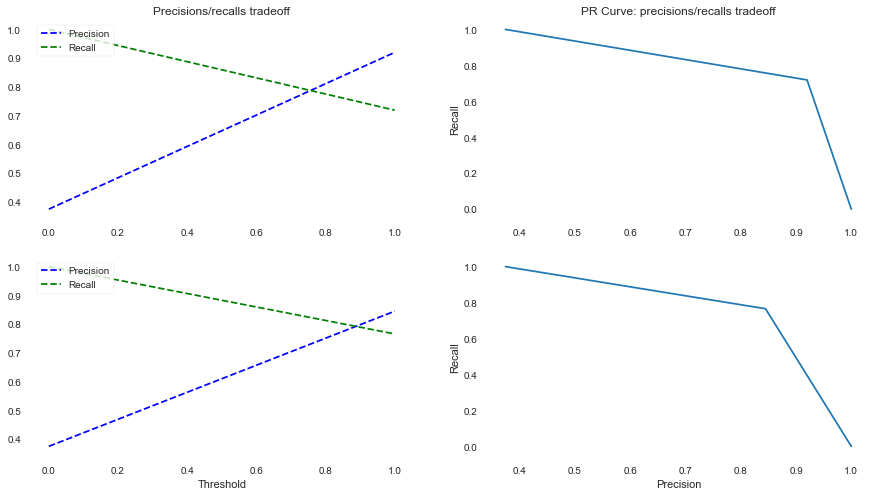

In [76]:
#This is for LogisticReg

precisions, recalls, thresholds = precision_recall_curve(y_test, LogisticReg_clf.predict(X_test))

plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Precisions/recalls tradeoff")

plt.subplot(2, 2, 2)
plt.plot(precisions, recalls)
plt.ylabel("Recall")
plt.title("PR Curve: precisions/recalls tradeoff")


#This is for SVC

precisions, recalls, thresholds = precision_recall_curve(y_test, svc.predict(X_test))

plt.subplot(2, 2, 3)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlabel("Threshold")

plt.subplot(2, 2, 4)
plt.plot(precisions, recalls)
plt.xlabel("Precision")
plt.ylabel("Recall")





<h2>Evaluate the performance of each model.</h2>

### Based on linear classification algorithm, relative to the same S.D, the SVM model and Logistic Regression model has the same AUC of 98.44%, however;
> - The accuracy score of Logistic Regression of 87% is higher than that of SVM of 85%. 
> - The Recall is higher for LogReg than SVC, whilst the rest of the stats is about the same
> - The Logistic Regression proportion of TP and FP precedes in advantage against the SVC model
> - The Logistic Regression is more accurate, although the false negative is higher for Logistic regression than SVM, the proportion of TP also increased whilst the FP also reduced.
> - In actual event we want to minimize the absolute numbers for False Negatives for an infectious virus such as covid, as this is not an infectious virus, hence a small difference of 3 would not have dire consequences for the patient. If is infectious virus such as predicting for covid then we focus on minimizing the absolute number.
> -We should not overtrain and overfit although the accuracy can go up slightly further, since overtraining may impact the optimal bias-variance and its replicability and generalisability of the model for the majority cases in future.

### The precision for SVC and LR is about the same, however the LR recall is higher. 
### Based on the parsimonous principle and the earlier comparatively similar result we should adopt the Logistic Regression model instead
>Note: <br>
> -Precision: The precision the correct positive predictions relative to total positive prediction <br>
> -Recall: Correct positive predictions relative to total actual positives <br>
> -Accuracy may not be meaningful than Precision-Recall especially when sample is imbalanced <br>


### In each model, identify the most important predictive variables and explain how you identified them. 
> -As discussed earlier, based on multi-collinearity issues, we have chosen two prominent variables that are not collinear with the rest, this is further validated in the feature selection technique
> - This therefore applies to both model, since multi-collinearity present a problem for classification model as well.
> - Because of that we choose 'fractal_dimension_mean'  and 'concave_points_sd_error'

[0.04925834 0.02321786 0.04325104 0.04381387 0.01146987 0.01712484
 0.04926238 0.08695836 0.00806222 0.00713081 0.01984076 0.00581564
 0.01528112 0.03250081 0.00524224 0.01091778 0.01058975 0.01102358
 0.0058394  0.00627111 0.09688747 0.02619712 0.10162385 0.08675565
 0.02134935 0.02840615 0.04464393 0.10908304 0.01136622 0.01081544]


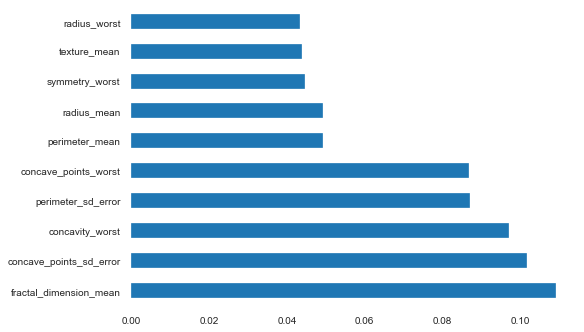

In [77]:
#perform a feature selection
X = df1.iloc[:,2:]  #IVs
y = df1.iloc[:,1]   #target column i.e diagnosis
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class

#feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()



### Explanation
### Technical Audience (Limitations and solutions)
> - The raw data may be non-parametric, feeding them a parametric model such as Logistic regression and SVC may be incorrect. However for Logistic regression the logit link function may circumvent to a little extent though assumption is mildly violated, whereas the SVC is parametric by the kernel choice i.e. RBF may make it non-parametric. The workaround is to run a data transformation and re-test for a pass in normality test before running the parametric model.
> - The outlier effect has been tested but the grubbs test would indicate there is outlier, since outlier will impact the generalisability of a scientific model.
> - After assessing those outliers separately in the csv most of them were contextual outliers. To enhance the performance outliers should be identified and examined for possible elimination
> - Resampling techniques such as stratified sampling are often better than just running train-test split without shuffling, however since we have shuffled the TTS and run a Stratified K Fold Validation it circumvent both bias-variance issue and imbalance class.

### Non Technical Audience
> - Summary: We have built and compared two models for detecting malignant tumors: SVM and Logistic Regression, which both of them performed equally well with 98.44% accuracy. However since they are similar, we observe the AUC which is especially relevant to identify the correct predictions. Overall, Logistic Regression classifer performed the best with highest accurate prediction of True Positives and lowest False Positives.

> - Although based on the AUC score the Logistic Regression is more accurate, the false negatives are higher in absolute number by 3. We should however consider the bigger picture in that the proportion of True positives have also increased, whilst the False Positive also reduced.
> - In actual event we ought to minimize the absolute numbers for False Negatives for an infectious virus such as covid, as this is not an infectious virus, hence a small difference of 3 would not have dire consequences for the patient. If is infectious virus such as predicting for covid then we focus on minimizing the absolute number. 
> - An analogy of False Positive is equitable to pregnancy test kit which gives false result that someone is pregnant, when in fact she isnt. That is detrimental to its brand amongst its competitor, since customers would avoid such brand in future.
> - Yet another analogy for False Negatives would be equitable to Covid ART test which gives false result that someone does not have covid, when in fact he has. This is critical since a positive person may have wrong impression that he is fine to continue his social gathering activities
> - We conclude that if False negatives are a concern for quoting patients to undergo chemotherapy when in fact he/she does not have cancer then we would find SVC to be more reliably conservative than Logistic Regression in identifying this subtleties or tackling these outlier cases.

> - Contributing factors in identification the above classifiers analyze the part of the data (train data) to learn how to differentiate between malignant and benign tumors. The classifers look at the relationship betweet the different measurement attributes and diagnosis attribute for this purpose. Apart from the number of training data and the relationship between the attributes, the quality of the data (like existance of missing values, outlier values etc.) is also a very important factor in identifying the malignant tumor from benign tumor.

<h1>PART II</h1>

### Code Snippet 1
> - Generally the student has exhibited a decent understanding in the basics including listing of the methodology for ML pipeline, however the student might have missed out in the area of deploying the code i.e. pickled, etc.... 
> - On the concepts, student did not understand that categorical data type does not perform well as an IV for Linear Regression, since the correlation and covariance cannot be calculated through the use Linear Regression. Student should conduct a test of variable i.e. ANOVA to determine if he/she should be able to use Contract Type to serve as an IV. There is also a need to check for normality in residuals. Depending on the dataset using MAE does not amplify the error compare to MSE or RMSE, hence it might not be ideal. Student would also need to check the IV for Multi-Collinearity problem if is categorical use chi-square test of independence or spearman instead of pearson, which is reportedly off.

### Strengths
> - library package imports are following the conventions. E.g. pandas as pd, numpy as np
> - package imports are also clear and explicit. Good that no * imports were used
> - variable name is labelled with consistency and clarity e.g. data = pd.read_csv('../data/train.csv')
> - Followed the convention of naming the dependent variable y and independent variable X.
> - imports were written at start of script before running other codes


### Areas For Improvements
> - All import statements should ideally at the top of the code sample.
> - d is not a good variable name. Variable name should be intuitive, for example here it could be train_df. Also, x1 and x2 are not very intuitive either. Conventionally, we use X for the features, and y for the labels.
> - For the import statement on line 3, it should be "from sklearn.linear_model import LinearRegression".
> - For the import statement on line 4, it dhould be "from sklearn.model_selection import cross_val_score"
> - It should be x1 = d.SalaryNormalized
> - It should be x2 = pd.get_dummies(d.ContractType)
> - The line "from sklearn.cross_validation import cross_val_score" and the line "from sklearn.cross_validation import train_test_split" can be replaced by a single line at the top - " from sklearn.model_selection import cross_val_score, train_test_split"
> - 'mean_absolute_error' is not a valid scoring value. A better option would be 'neg_mean_absolute_error'.
> - I'd add comments on each line to clarify what exactly I'm trying to do.
> - k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more.
> - Avoid importing modules that you dont use, eg: import numpy as np.

### Code Snippet 2

> - Generally the student has exhibited a decent understanding in the basics including listing of the methodology for ML pipeline, however the student might have missed out in the area of deploying the code i.e. pickled, etc.... 
> - On the concepts, student did not understand that categorical data type does not perform well as an IV for Linear Regression, since the correlation and covariance cannot be calculated through the use Linear Regression. Student should conduct a test of variable i.e. ANOVA to determine if he/she should be able to use Contract Type to serve as an IV. There is also a need to check for normality in residuals. Depending on the dataset using MAE does not amplify the error compare to MSE or RMSE, hence it might not be ideal. Student would also need to check the IV for Multi-Collinearity problem if is categorical use chi-square test of independence or spearman instead of pearson, which is reportedly off.

### Strengths
> - Appropriately performed one hot encoding on the independent variable ContractType, a categorical variable.
> - The model used is a regression model, so it is the correct type of model to use for this regression problem.
> - without splitting the data into training and validation data, the student correctly intended to use cross validation (cross_val_score) to estimate the performance of the model if deployed into production.
> - Student used 1 of the correction scoring metrices for a regression problem.

### Areas For Improvements
> - For the import statement on line 4, it should be "from sklearn.model_selection import cross_val_score"
> - 'mean_absolute_error' is not a valid scoring value. A better option would be 'neg_mean_absolute_error'.
> - Avoid importing modules that you don't use: Eg: import numpy as np